In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'

In [3]:
def load_data(train_batch_size, test_batch_size):
    # Fetch training data: total 60000 samples
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    # Fetch test data: total 10000 samples
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [4]:
#LeNet
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.cn1 = nn.Conv2d(1, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)
        self.lin1 = nn.Linear(16 * 5 * 5, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.cn1(x)), 2)
        x = F.max_pool2d(F.relu(self.cn2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [5]:
#CNN
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.cn1 = nn.Conv2d(1, 32, 5)
        self.cn2 = nn.Conv2d(32, 32, 5)
        self.cn3 = nn.Conv2d(32, 64, 5)
        self.lin1 = nn.Linear(1024, 256)
        self.lin2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.relu(F.max_pool2d(self.cn2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.cn3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [6]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 6946998.90it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:02<00:00, 785368.77it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [7]:
def train(model, optimizer, epoch, train_loader):
    loss_fun = torch.nn.CrossEntropyLoss()
    final_loss = 0
    samples = 0
    count = 0
    right_predictions = 0
    for batch_id, (x, target) in enumerate(train_loader):
        count += 1
        x, res_p = Variable(x), Variable(target)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fun(output, res_p)
        loss.backward()
        optimizer.step()
        pred_op = np.argmax(output.data, axis=1)
        samples += target.size(0)
        right_predictions += (pred_op == res_p).sum().item()
        acc = 100.0 * right_predictions/samples
        final_loss = final_loss + loss.data
        if batch_id % 200 == 0:
            print('Train set, Epoch {} \tLoss: {:.6f}'.format(
                epoch, batch_id+1, len(train_loader.dataset),
                loss.data))
            print("Accuracy: ", round(acc,2))
    final_loss /= count
    return final_loss, round(acc,2)

In [8]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += loss_fn(output, target).data
        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
torch.manual_seed(1)
model= Model1() #LeNet
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
loss_arr1 = []
acc_arr1 = []
epochs = 10
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader)
    loss_arr1.append(loss)
    acc_arr1.append(acc)

Train set, Epoch 1 [0/60000]	Loss: 2.322259
Train Accuracy:  10.94
Train set, Epoch 1 [12800/60000]	Loss: 0.390229
Train Accuracy:  46.47
Train set, Epoch 1 [25600/60000]	Loss: 0.321334
Train Accuracy:  66.1
Train set, Epoch 1 [38400/60000]	Loss: 0.252715
Train Accuracy:  74.57
Train set, Epoch 1 [51200/60000]	Loss: 0.254497
Train Accuracy:  79.36


C:\Users\SRICHARAN\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 0.1388, Accuracy: 9584/10000 (96%)

Train set, Epoch 2 [0/60000]	Loss: 0.164945
Train Accuracy:  93.75
Train set, Epoch 2 [12800/60000]	Loss: 0.138806
Train Accuracy:  95.42
Train set, Epoch 2 [25600/60000]	Loss: 0.362655
Train Accuracy:  95.67
Train set, Epoch 2 [38400/60000]	Loss: 0.087891
Train Accuracy:  95.92
Train set, Epoch 2 [51200/60000]	Loss: 0.111992
Train Accuracy:  96.13

Test set, Epoch 2 , Average loss: 0.0777, Accuracy: 9752/10000 (98%)

Train set, Epoch 3 [0/60000]	Loss: 0.025260
Train Accuracy:  100.0
Train set, Epoch 3 [12800/60000]	Loss: 0.079114
Train Accuracy:  97.37
Train set, Epoch 3 [25600/60000]	Loss: 0.054100
Train Accuracy:  97.35
Train set, Epoch 3 [38400/60000]	Loss: 0.038590
Train Accuracy:  97.44
Train set, Epoch 3 [51200/60000]	Loss: 0.075013
Train Accuracy:  97.45

Test set, Epoch 3 , Average loss: 0.0681, Accuracy: 9776/10000 (98%)

Train set, Epoch 4 [0/60000]	Loss: 0.119911
Train Accuracy:  98.44
Train set, Epoch 4

In [10]:
torch.manual_seed(1)
model= Model2() #CNN
optimizer = optim.SGD(model.parameters(),lr = 0.01,momentum = 0.5)
loss_arr2 = []
acc_arr2 = []
epochs = 10
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader)
    loss_arr2.append(loss)
    acc_arr2.append(acc)

Train set, Epoch 1 [0/60000]	Loss: 2.315159
Train Accuracy:  6.25
Train set, Epoch 1 [6400/60000]	Loss: 1.539017
Train Accuracy:  24.57
Train set, Epoch 1 [12800/60000]	Loss: 0.914072
Train Accuracy:  45.83
Train set, Epoch 1 [19200/60000]	Loss: 0.388471
Train Accuracy:  57.54
Train set, Epoch 1 [25600/60000]	Loss: 0.418852
Train Accuracy:  64.57
Train set, Epoch 1 [32000/60000]	Loss: 0.289600
Train Accuracy:  69.04
Train set, Epoch 1 [38400/60000]	Loss: 0.390969
Train Accuracy:  72.33
Train set, Epoch 1 [44800/60000]	Loss: 0.291935
Train Accuracy:  74.94
Train set, Epoch 1 [51200/60000]	Loss: 0.275580
Train Accuracy:  76.96
Train set, Epoch 1 [57600/60000]	Loss: 0.472766
Train Accuracy:  78.63

Test set, Epoch 1 , Average loss: 0.1197, Accuracy: 9634/10000 (96%)

Train set, Epoch 2 [0/60000]	Loss: 0.261209
Train Accuracy:  93.75
Train set, Epoch 2 [6400/60000]	Loss: 0.222863
Train Accuracy:  93.24
Train set, Epoch 2 [12800/60000]	Loss: 0.173425
Train Accuracy:  93.23
Train set, Epoch 

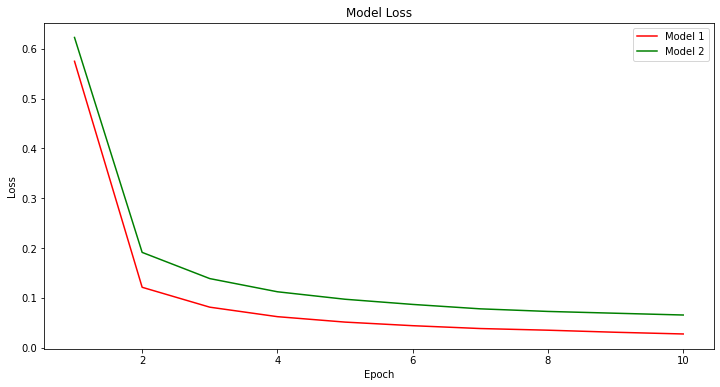

In [11]:
plt.figure(figsize=(14,6))
plt.plot( loss_arr1, color = "red")
plt.plot( loss_arr1, color = "green")
plt.title('Model Loss')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

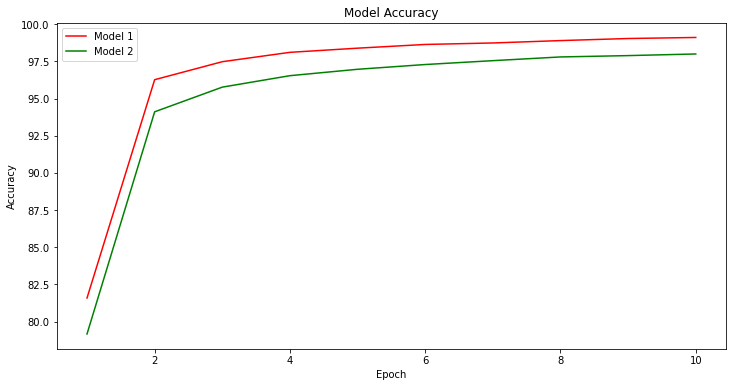

In [12]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(1, 11, 1), acc_arr2, color = "red")
plt.plot(np.arange(1, 11, 1), acc_arr2, color = "green")
plt.title('Model Accuracy')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()